##### PLOTTER OF THE RESULTS OF A GRID SEARCH

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import t


In [2]:
output_dir = "/home/zhanna/bachelorarbeit/zbb/experiments/output_grid_search_10_12_23"
output_dir = "/home/zhanna/bachelorarbeit/zbb/experiments/output_grid_search_000"

In [3]:
model_names = [
    "RandomForestW2V",
    # "RandomForest",
    # "LogisticRegression",
    # "LogisticRegressionW2V",
    # "NaiveSA",
    # "AFinn",
    # "Vader"
]

model_name = model_names[0]

In [4]:
import numpy as np
from scipy.stats import t

def get_model_scores(metric):
    model_scores = results_df.filter(regex=r"split\d*_test_{}".format(metric))
    return model_scores


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

def compare_models(X1, X2, n_train, n_test):
    # print(model_scores)

    differences = X1 - X2

    n = differences.shape[0]  # number of test sets
    df = n - 1
    # n_train = len(list(cv.split(X, y))[0][0])
    # n_test = len(list(cv.split(X, y))[0][1])

    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    print(f"Corrected t-value: {t_stat:.10f}\nCorrected p-value: {p_val:.10f}")

    # ==============================================================================

    t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
    p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

    print(
        f"Uncorrected t-value: {t_stat_uncorrected:.10f}\n"
        f"Uncorrected p-value: {p_val_uncorrected:.10f}"
    )
    return t_stat, p_val, t_stat_uncorrected, p_val_uncorrected

In [5]:
n_train = 45000
n_test = 5000

In [6]:
file_name = os.path.join(output_dir, 'grid_search_{}_cv_results.pkl'.format(model_name))
with open(file_name, 'rb') as f:
    results = pickle.load(f)
results_df = pd.DataFrame(results)
# results_df.columns

model_scores = get_model_scores("precision")
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

t_corr, p_corr, t_std, p_std = compare_models(model_1_scores, model_2_scores, n_train, n_test)

Corrected t-value: -4.0622363515
Corrected p-value: 0.0000486978
Uncorrected t-value: -14.1369975405
Uncorrected p-value: 0.0000000000


In [7]:
differences = model_1_scores - model_2_scores
n = differences.shape[0]  # number of test sets
df = n - 1


# initialize random variable
t_post = t(
    df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
)

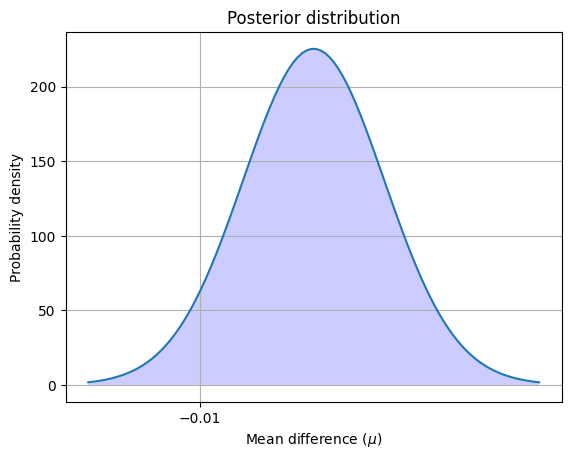

In [8]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.grid('minor')
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

In [9]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of 0 being more accurate than 1: 0.000
Probability of 1 being more accurate than 0: 1.000


In [10]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"being practically equivalent: {rope_prob:.3f}"
)


Probability of 0 and 1 being practically equivalent: 0.944


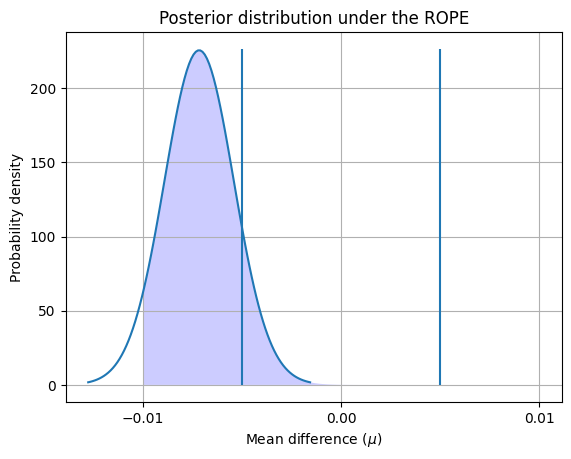

In [11]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.grid('minor')
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.005, 0.005], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

In [12]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,-0.008363,-0.005974
0.75,-0.009210,-0.005126
0.95,-0.010670,-0.003667


In [13]:
from itertools import combinations
from math import factorial

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,0,1,-4.062,0.001
1,0,2,-0.871,1.000
2,0,3,-3.465,0.006
3,0,4,17.640,0.000
4,0,5,14.504,0.000
5,1,2,2.921,0.032
6,1,3,0.282,1.000
7,1,4,21.885,0.000
8,1,5,19.216,0.000
9,2,3,-3.073,0.021


In [14]:
print(pairwise_comp_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & model_1 & model_2 & t_stat & p_val \\
\midrule
0 & 0 & 1 & -4.062000 & 0.001000 \\
1 & 0 & 2 & -0.871000 & 1.000000 \\
2 & 0 & 3 & -3.465000 & 0.006000 \\
3 & 0 & 4 & 17.640000 & 0.000000 \\
4 & 0 & 5 & 14.504000 & 0.000000 \\
5 & 1 & 2 & 2.921000 & 0.032000 \\
6 & 1 & 3 & 0.282000 & 1.000000 \\
7 & 1 & 4 & 21.885000 & 0.000000 \\
8 & 1 & 5 & 19.216000 & 0.000000 \\
9 & 2 & 3 & -3.073000 & 0.021000 \\
10 & 2 & 4 & 17.215000 & 0.000000 \\
11 & 2 & 5 & 15.546000 & 0.000000 \\
12 & 3 & 4 & 19.521000 & 0.000000 \\
13 & 3 & 5 & 17.589000 & 0.000000 \\
14 & 4 & 5 & -3.595000 & 0.004000 \\
\bottomrule
\end{tabular}



In [15]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df


,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,0,1,-4.062,0.001,0.056,0.00,0.944
1,0,2,-0.871,1.000,0.000,0.00,1.000
2,0,3,-3.465,0.006,0.042,0.00,0.958
3,0,4,17.640,0.000,0.000,1.00,0.000
4,0,5,14.504,0.000,0.000,1.00,0.000
5,1,2,2.921,0.032,0.000,0.01,0.990
6,1,3,0.282,1.000,0.000,0.00,1.000
7,1,4,21.885,0.000,0.000,1.00,0.000
8,1,5,19.216,0.000,0.000,1.00,0.000
9,2,3,-3.073,0.021,0.001,0.00,0.999
